[*********************100%%**********************]  10 of 10 completed


포트폴리오 가중치 (블랙-리터만 모델):
기아 (000270.KS): 1.08%
SK하이닉스 (000660.KS): 10.86%
삼성화재 (000810.KS): 10.86%
DB손해보험 (005830.KS): 10.86%
삼성전자 (005930.KS): 12.06%
SK가스 (018670.KS): 10.86%
한국가스공사 (036460.KS): 10.86%
KB금융 (105560.KS): 10.86%
HD현대 (267250.KS): 10.86%
LG에너지솔루션 (373220.KS): 10.86%
Expected annual return: 20.2%
Annual volatility: 17.6%
Sharpe Ratio: 1.03


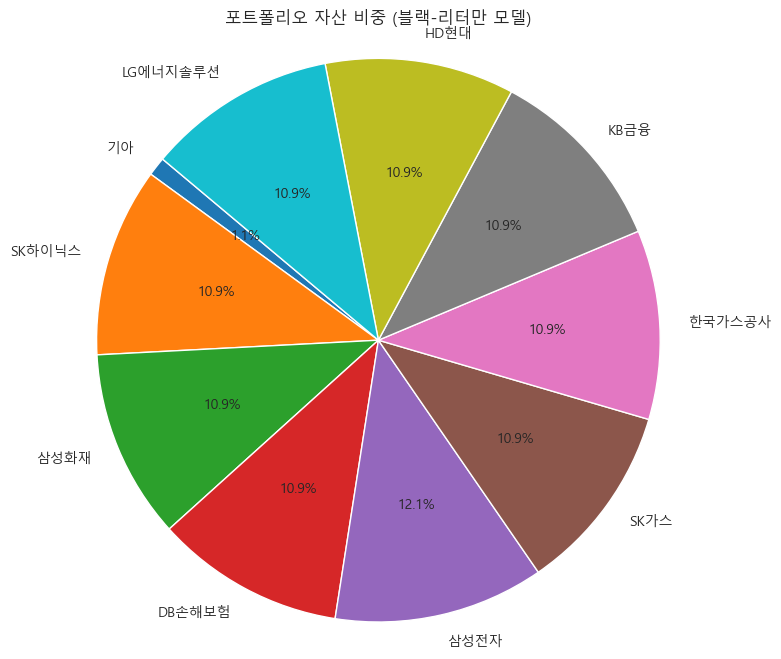


총 누적 수익률: 69.25%
연간화된 누적 수익률: 25.24%
초기 투자금액: 1,000,000.00 원
만기 투자금액: 1,692,529.89 원
총 배당금: 159,161.62 원


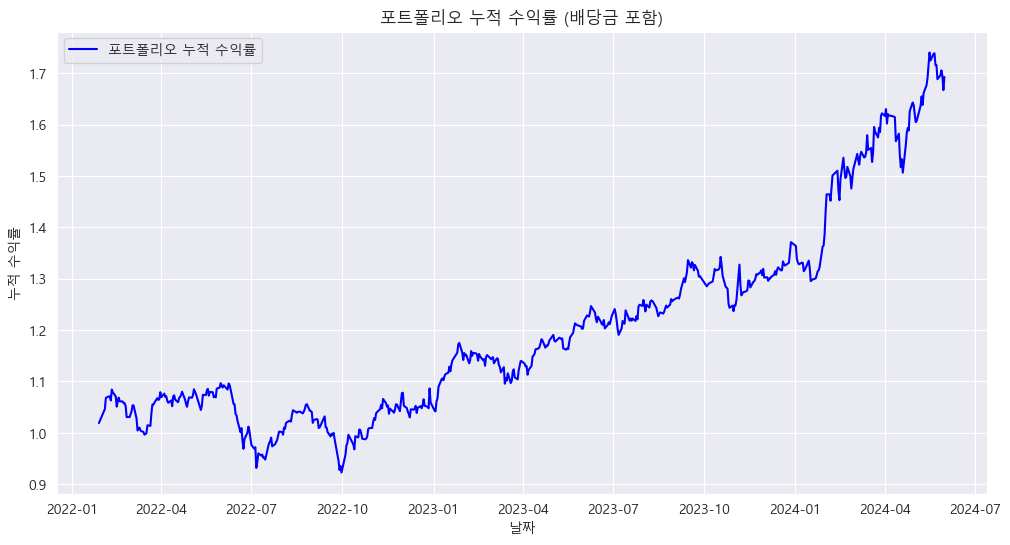

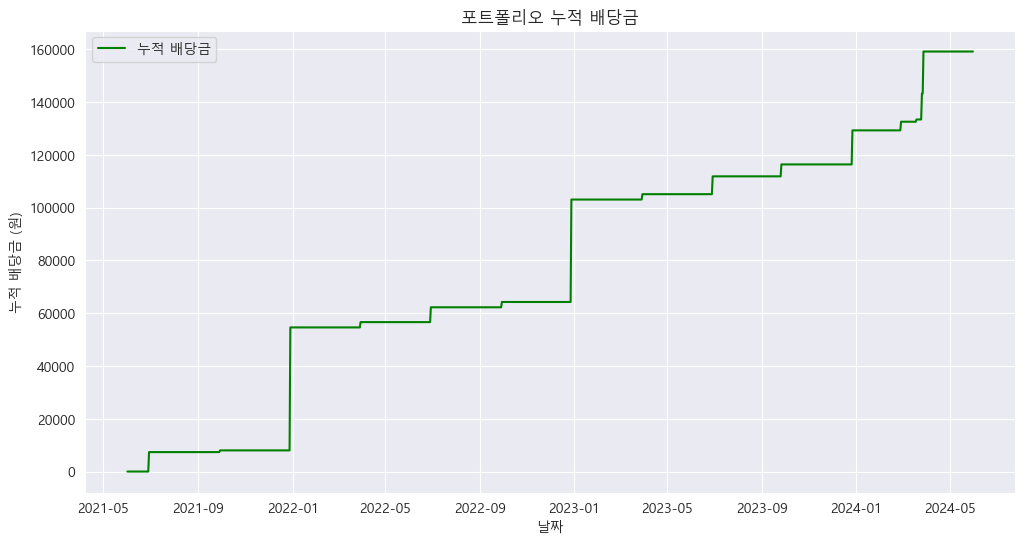

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from datetime import datetime
from pypfopt import BlackLittermanModel, risk_models, expected_returns, EfficientFrontier

# 시드 고정 (재현성 확보)
np.random.seed(42)

# Seaborn 스타일 설정
sns.set_style('darkgrid')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우의 경우
# plt.rcParams['font.family'] = 'NanumGothic'  # 리눅스/맥의 경우
# plt.rcParams['font.family'] = 'AppleGothic'  # 맥의 경우

# 마이너스 기호가 깨지는 문제 해결
plt.rcParams['axes.unicode_minus'] = False

# 자산 리스트 및 회사명 정의
asset_info = [
    {"ticker": "267250.KS", "name": "HD현대"},
    {"ticker": "018670.KS", "name": "SK가스"},
    {"ticker": "005830.KS", "name": "DB손해보험"},
    {"ticker": "000810.KS", "name": "삼성화재"},
    {"ticker": "000270.KS", "name": "기아"},
    {"ticker": "000660.KS", "name": "SK하이닉스"},
    {"ticker": "036460.KS", "name": "한국가스공사"},
    {"ticker": "005930.KS", "name": "삼성전자"},
    {"ticker": "105560.KS", "name": "KB금융"},
    {"ticker": "373220.KS", "name": "LG에너지솔루션"}
]

asset_list = [asset['ticker'] for asset in asset_info]
asset_names = {asset['ticker']: asset['name'] for asset in asset_info}

# 시작일과 종료일 설정
start_date = '2021-06-01'
end_date = '2024-06-01'

# 초기 투자금액 설정
initial_investment = 1_000_000  # 1,000,000 원

# yfinance를 사용하여 조정 종가 및 배당금 데이터 수집
data = yf.download(asset_list, start=start_date, end=end_date, actions=True)

# 조정 종가 데이터 추출
price_data = data['Adj Close']

# 배당금 데이터 추출
dividend_data = data['Dividends']

# 결측치 보간 및 제거
price_data = price_data.ffill().dropna()

# 배당금 데이터 결측치 0으로 채우기
dividend_data = dividend_data.fillna(0)

# 일일 수익률 계산
returns = price_data.pct_change().dropna()

# 공분산 행렬 계산
S = risk_models.sample_cov(price_data)

# 시장의 균형 예상 수익률 (CAPM 기반)
mu = expected_returns.capm_return(price_data)

# 투자자의 주관적 견해(Views) 설정
# 절대적 기대 수익률을 설정
absolute_views = pd.Series({
    '005930.KS': 0.15,  # 삼성전자
    '000270.KS': 0.10   # 기아
})

# 각 견해에 대한 신뢰도 설정 (예: 50% 신뢰도)
# 신뢰도는 0과 1 사이의 값으로 설정
confidence = np.array([0.5, 0.5])  # 견해의 순서와 일치해야 함

# 블랙-리터만 모형 설정
bl = BlackLittermanModel(
    S,
    pi=mu,
    absolute_views=absolute_views,
    omega='idzorek',
    view_confidences=confidence
)

# 블랙-리터만 예상 수익률 계산
bl_mu = bl.bl_returns()

# 포트폴리오 최적화
ef = EfficientFrontier(bl_mu, S)
weights = ef.max_sharpe()  # 최대 샤프 비율 포트폴리오

# 가중치 정리 (소수점 이하 두 자리)
cleaned_weights = ef.clean_weights()
print("포트폴리오 가중치 (블랙-리터만 모델):")
for ticker, weight in cleaned_weights.items():
    if weight > 0:
        print(f"{asset_names[ticker]} ({ticker}): {weight*100:.2f}%")

# 포트폴리오 성과 요약
performance = ef.portfolio_performance(verbose=True)

# 포트폴리오 가중치 시각화
fig, ax = plt.subplots(figsize=(8, 8))
labels = [asset_names[ticker] for ticker in cleaned_weights.keys() if cleaned_weights[ticker] > 0]
sizes = [weight for weight in cleaned_weights.values() if weight > 0]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('포트폴리오 자산 비중 (블랙-리터만 모델)')
plt.show()

# 배당금 계산
# 각 자산의 투자금액을 계산
investment_per_asset = initial_investment * pd.Series(cleaned_weights)

# 각 자산의 구매한 주식 수 계산 (가장 첫날의 가격 기준)
first_price = price_data.iloc[0]
shares = investment_per_asset / first_price

# 배당금 계산: 배당금 per share * shares
total_dividends = pd.Series(0, index=dividend_data.index)
for ticker in asset_list:
    if ticker in dividend_data.columns:
        ticker_dividends = dividend_data[ticker]
        total_dividends += ticker_dividends * shares.get(ticker, 0)
    else:
        total_dividends += 0

# 누적 배당금 계산
cumulative_dividends = total_dividends.cumsum()

# 포트폴리오 일일 수익률 계산 (배당금 포함)
portfolio_returns = returns.multiply(cleaned_weights, axis=1).sum(axis=1)
portfolio_returns += (total_dividends / initial_investment)

# 누적 수익률 계산
cumulative_returns = (1 + portfolio_returns).cumprod()

# 최종 투자금액 계산
final_value_without_dividend = initial_investment * cumulative_returns.iloc[-1]
final_value = final_value_without_dividend  # 이미 배당금이 포함됨

# 총 누적 수익률 계산
total_cumulative_return = cumulative_returns.iloc[-1] - 1  # 최종 누적 수익률
print(f"\n총 누적 수익률: {total_cumulative_return * 100:.2f}%")

# 연간화된 누적 수익률 계산
total_days = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days
total_years = total_days / 365.25  # 윤년 고려

annualized_return = (cumulative_returns.iloc[-1]) ** (1 / total_years) - 1
print(f"연간화된 누적 수익률: {annualized_return * 100:.2f}%")

# 결과 출력
print(f"초기 투자금액: {initial_investment:,.2f} 원")
print(f"만기 투자금액: {final_value:,.2f} 원")
print(f"총 배당금: {total_dividends.sum():,.2f} 원")

# 누적 수익률 시각화
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values, label='포트폴리오 누적 수익률', color='b')
plt.title('포트폴리오 누적 수익률 (배당금 포함)')
plt.xlabel('날짜')
plt.ylabel('누적 수익률')
plt.legend()
plt.grid(True)
plt.show()

# 누적 배당금 시각화
plt.figure(figsize=(12, 6))
plt.plot(cumulative_dividends.index, cumulative_dividends.values, label='누적 배당금', color='g')
plt.title('포트폴리오 누적 배당금')
plt.xlabel('날짜')
plt.ylabel('누적 배당금 (원)')
plt.legend()
plt.grid(True)
plt.show()
